In [1]:
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np

import os

In [4]:
DATASET_PATH = "../../datasets/google-drawings/"
x = np.load(DATASET_PATH+"full_numpy_bitmap_axe.npy")
x.shape, x.dtype

((1000, 784), dtype('uint8'))

129


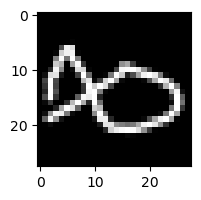

In [9]:
print(len(os.listdir(DATASET_PATH)))

# 138 files
# all containing 1000 images
# removed duplicate ... (n).npy files
# seemed to have repeated images

img = np.load(DATASET_PATH+"full_numpy_bitmap_fish.npy")[1]
img = img.reshape(28,28)

plt.figure(figsize=(2,2))
plt.imshow(img, cmap='gray')

In [220]:
files = os.listdir(DATASET_PATH)
files = sorted([name for name in files if ".npy" in name and "sketch" not in name])
n_classes = len(files) 
print(len(files), n_classes)

BS = 32

def load_batch(BS):
    
    batch = torch.zeros((BS, 1, 28, 28))
    labels = torch.zeros(BS).type(torch.uint8)
    #print(labels.shape)
    #print(batch.shape)

    # 130 file
    # 1000 samples per file
    file_indices = np.random.randint(0, n_classes, BS)
    batch_indices = np.random.randint(0, 1000, BS)
    
    for i, (fi, bi) in enumerate(zip(file_indices, batch_indices)):
        
        item = np.load(DATASET_PATH+files[fi])[bi]
        batch[i] = torch.from_numpy(item).type(torch.float).reshape(28,28)
        #labels[i] = F.one_hot(torch.tensor(fi), 128)
        labels[i] = torch.tensor(fi)
        
    return batch, labels

xs, ys = load_batch(2)
xs.shape, ys

128 128


(torch.Size([2, 1, 28, 28]), tensor([62, 55], dtype=torch.uint8))

In [258]:
class mlp(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),            
            nn.Linear(256, 128),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layer_stack(x)
    
device = torch.device("mps")    
model = mlp()
#model = model.to(device)

pred = model(xs)
print(pred.shape)

crit = nn.NLLLoss()

crit(pred, ys)

torch.Size([2, 128])


tensor(-0.0071, grad_fn=<NllLossBackward0>)

In [261]:
device = torch.device("cpu")
model = model.to(device)
model.train()


mlp(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): Softmax(dim=1)
  )
)

In [268]:
lr = 0.1
mom = 0.1
BS = 512
N_EPOCHS = 15
N_BATCHES = int(128*1000/BS)

crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=mom)

losses = []
accs = []

pbar = tqdm(range(N_EPOCHS))

for epoch in pbar:
    for n_batch in range(N_BATCHES):
        batch, labels = load_batch(BS)
        
        optim.zero_grad()

        out = model.forward(batch.to(device))
        loss = crit(out, labels.to(device))
        acc = ((out.argmax(dim=1).detach().cpu()==labels).sum().item()/float(BS))
        
        accs.append(acc)
        losses.append(loss.detach().cpu().item()/float(BS))

        if n_batch % 3 == 0: pbar.set_description(str(acc))
        
        loss.backward()
        
        optim.step()
        

0.109375: 100%|████████████████████████████████████| 15/15 [03:23<00:00, 13.54s/it]


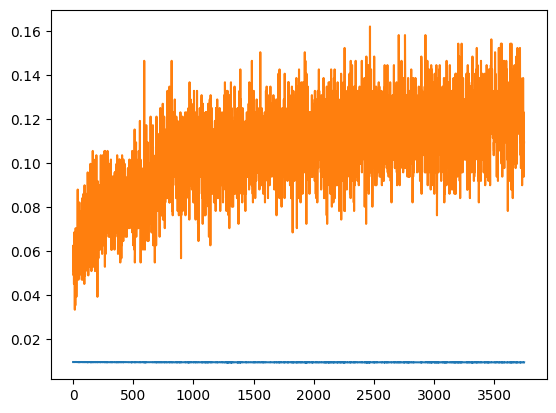

In [269]:
plt.plot(losses)
plt.plot(accs)